# Bathymetric particle filter 

This notebook is a testing and development environment for the geophysical particle filter. As of 30 December 2024 the initial implementation will be a velocity-state based implementation that does not do the proposed full state mechanization. The full state mechanization will be implemented in the future under a ROS2 and Gazebo simulation environment that allows for more realistic (and reliable) IMU simulation.

This notebook is meant for interactive testing and development and should not be used for large-scale simulations. The intended workflow is to use the notebook to test and develop the particle filter on a small subsample of test data, then build and install it in the local virtual environment for use in the full simulation.

This full simulation should then be written in the `/scripts` folder with result data saved off there.

## Simulation parameters verification

First we need to tune the particle filter propagation noise to be similar to that of a marine-grade inertial navigation system. A low-end marine-grade INS should have a drift of 1 nm per 24 hours. Our typical time interval is 60 seconds and the noise parameters for velocities states need to be tuned based on this value.

In [10]:
from src.geophysical.particle_filter import propagate_ned, rmse
import numpy as np

def run_velocity_loop(u:np.ndarray, noise:np.ndarray, dt:float = 60.0, time:int = 24*60) -> float:
    P = np.asarray([[0, 0, 0, u[0], u[1], u[2]]])
    T = P.copy()
    t = 0
    while t < time:
        P = propagate_ned(P, u, dt) #noise=np.diag(noise), noise_calibration_mode=True)
        # Add zero-mean noise to the particles
        P += np.random.multivariate_normal(np.zeros(6), np.diag(noise))
        T = propagate_ned(T, u, dt) #noise=np.diag([0, 0, 0]), noise_calibration_mode=False)
        t += 1
    error = rmse(P, T, include_altitude=True)
    return error

In [47]:
from tqdm import tqdm
import matplotlib.pyplot as plt

In [ ]:
time = 24 * 60  # minutes
vel_noise = 1.75  # m/s
noise = np.array([0, 0, 0, vel_noise, vel_noise, 0.01])
bound = 1852  # meters
errors = []
errors_dict = {}
for i in range(1, 26): # 1 to 25 nautical miles per hour
    print(f"Running for {i} knots")
    v = i * bound / 3600  # convert to m/s
    for a in tqdm(range(1000)):
        # Eastward
        u = np.asarray([0.0, v, 0.0])
        errors.append(run_velocity_loop(u, noise))
        # Northward
        u = np.asarray([v, 0, 0])
        errors.append(run_velocity_loop(u, noise))
        # Northeastward
        u = np.array([1, 1, 0]) / np.linalg.norm([1, 1, 0])
        u *= v
        errors.append(run_velocity_loop(u, noise))
    errors_dict[i] = errors.copy()
    print(f"Mean RMSE: {np.mean(errors): 0.2f} meters")
print(f"Overall RMSE: {np.mean(errors)}")
# Plot the previous

plt.figure(figsize=(12, 4))
plt.violinplot(errors_dict.values(), showmeans=True, showmedians=True)
plt.axhline(y=1852, color='k', linestyle='--', label='1 Nautical Mile')
plt.axhline(np.mean(errors), color='r', linestyle='-', label='Mean Error')
plt.xlabel("Velocity (knots)")
plt.ylabel("Error (meters)")
plt.title("Velocity Noise Tuning Error Distributions")
plt.legend(loc="upper left")
plt.savefig("velocity_noise_tuning.png")
plt.show()


Finalized noise model: $\begin{bmatrix} 0 & 0 & 0 & 1.75 & 1.75 & 0.01 \end{bmatrix}$

---------

## Develop measurement model

Next we need to develop the measurement value standard deviation. We'll first do some general examination of the data. Namely, investigating the sensor measurements to see if we can build a reasonable sensor model.

In [49]:
from src.data_management import dbmgr

In [50]:
db = dbmgr.DatabaseManager(".db")
summary = db.get_all_trajectories()
summary = summary.drop(summary.index[-1])
bathy_trajectories = summary[summary["depth"]]

In [ ]:
from src.geophysical import gmt_toolbox as gmt
from tqdm import tqdm

bathy_differences = np.empty((0,))

for id in tqdm(bathy_trajectories["id"]):
    data = db.get_trajectory(id)
    min_lon = data['lon'].min()
    max_lon = data['lon'].max()
    min_lat = data['lat'].min()
    max_lat = data['lat'].max()
    # min_lon, min_lat, max_lon, max_lat = gmt.inflate_bounds(min_lon, min_lat, max_lon, max_lat, 0.25)
    try:
        bathy_map = gmt.GeophysicalMap(gmt.MeasurementType.BATHYMETRY, 
                                   gmt.ReliefResolution.FIFTEEN_SECONDS, 
                                   min_lon, max_lon, min_lat, max_lat, 0.25)
    except AssertionError:
        if min_lat == max_lat:
            min_lat -= 0.25
            max_lat += 0.25
        if min_lon == max_lon:
            min_lon -= 0.25
            max_lon += 0.25
        bathy_map = gmt.GeophysicalMap(gmt.MeasurementType.BATHYMETRY, 
                                   gmt.ReliefResolution.FIFTEEN_SECONDS, 
                                   min_lon, max_lon, min_lat, max_lat, 0.1)
    except:
        print(f"Failed to get bathymetry map for {id}: {min_lon}, {max_lon}, {min_lat}, {max_lat}")
    #d_bathy = np.hstack([d_bathy, data["DEPTH"] - (-get_map_point(bathy_map, data.LON, data.LAT))])
    bathy_differences = np.append(bathy_differences, data["depth"] - (-bathy_map.get_map_point(data['lon'], data['lat'])))

bathy_mean_d = np.mean(bathy_differences, where=~np.isnan(bathy_differences))
bathy_std = np.std(bathy_differences, where=~np.isnan(bathy_differences))

In [ ]:
from scipy.stats import mode

def plot_measurement_statistics(data:np.ndarray, title:str, xlabel:str, ylabel:str, filename:str, bin_count:int=1000, xlims:tuple=None):
    Mean = np.mean(data, where=~np.isnan(data))
    Std = np.std(data, where=~np.isnan(data))
    Median = np.median(data[~np.isnan(data)])
    Mode = mode(data[~np.isnan(data)]).mode
    plt.figure(figsize=(8, 4))
    plt.hist(data, bins=bin_count, density=True, alpha=0.75)
    plt.axvline(Mean, color='r', linestyle='--', label=f'Mean={Mean:0.2f}')
    plt.axvline(Mean + Std, color='k', linestyle='--', label=f'$\pm\sigma={Std:0.2f}$')
    plt.axvline(Mean - Std, color='k', linestyle='--')
    plt.axvline(Median, color='g', linestyle='--', label=f'Median={Median:0.2f}')
    plt.axvline(Mode, color='b', linestyle='--', label=f'Mode={Mode:0.2f}')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if xlims is not None:
        plt.xlim(xlims)
    plt.title(title)
    plt.legend(loc="upper left")
    plt.savefig(filename)
    plt.show()

Using the above, let's plot the data and see if we can build a reasonable sensor model.

In [ ]:
plot_measurement_statistics(bathy_differences, "Raw Bathymetry Measurement Statistics", "Difference (meters)", "Density", "bathy_diff_stats_raw.png", xlims=(-1000, 1000))
print(f"Max: {np.max(bathy_differences[~np.isnan(bathy_differences)])}")

So from the above we can see that the data resembles a normal distribution, but has some substantial outliers. So let's filter out the outliers and then plot the data again.

In [ ]:
# Filter out the outliers
bathy_differences_filtered = bathy_differences[np.abs(bathy_differences - bathy_mean_d) < 3 * bathy_std]
plot_measurement_statistics(bathy_differences_filtered, "Filtered Bathymetry Measurement Statistics", "Difference (meters)", "Density", "bathy_diff_stats_filtered.png", xlims=(-250, 250))

With the filtered data we can see that the data is much more normally distributed. We can now use this data to build a sensor model for the particle filter. This model is a simple zero-mean normal distribution with a standard deviation of 100 meters. The statistical mean of the data suggests that there might be a sensor bias, but do to the fact that bathymetric measurements provide a direct measurement of the vertical state, it is unclear if this is an error in the sensor or the state estimate.

--------------------

## Experimental configuration

There are a few questions that can be answered with this simulation:

1. As a general long-term navigation aide - akin to a GPS system - how well does the particle filter perform? This can be answered by running the particle filter with a well-known initial state and tracking the drift error over time.
2. How well does the particle filter perform in a short-term navigation scenario? In other words, given a de-localized INS, how well does the particle filter perform in recovering the true state? This scenario poses a more specific scenario where the platform needs a position fix from GPS but is unable to get one.

I'll analyze both scenarios in this notebook by using two different initial states. The first state will be a well-known state (akin to a GPS fix) and the second will be a de-localized state (delocalized to a drift rate ~1 nmi).

### Performance criteria

The performance of the particle filter will be evaluated based on the following haversine distance error criteria:
1. Overall weighted root-mean-square error of the entire particle cloud (a measure of the overall accuracy of the particle filter)
2. Haversine error of the particle filter estimate (weighted average of all particles)
3. Wasserstein distance between the particle filter estimate and the true state (a measure of the distribution of the particle filter estimate) where the covariance (variance along the diagonal) matrix is derived from the particle field.
These criteria should ultimately be used to evaluate the performance with respect to two concepts: the overall accuracy of the particle filter estimate to recover truth, and with respect to the distance traveled by the platform.

### Truth model

The source data used in this experiment is fundamentally survey data (i.e. measurements that are time stamped and geolocated). I simulate IMU data in order to develop a trajectory, but this isn't specifically recorded IMU data. In order to generate a seperate effective truth, the simulated IMU data is integrated to generate an INS trajectory. This integrated trajectory is then in need of correction. For a truth comparison, I then use the GPS locations of the geophysical measurements to correct the IMU integration to develop a "Truth" trajectory. The same integrated trajectory is then used (through the NED velocities) to propagate the particle filter. The particle filter itself then is corrected using the bathymetric measurements. The error metric are then a comparison of the particle filter's estimate to the INS's "truth" estimate.

In [12]:
import os       
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from pyins import transform
from src.geophysical import gmt_toolbox as gmt
#####
from src.data_management import dbmgr
from src.geophysical import particle_filter as pf
from src.geophysical.gmt_toolbox import GeophysicalMap, MeasurementType, ReliefResolution
import haversine as hs
import h5py
from tqdm import tqdm

def save_simulation_results(filename:str, 
                            pf_result:pd.DataFrame, 
                            trajectory:pd.DataFrame, 
                            trajectory_sd:pd.DataFrame):
    # Create an HDF5 file
    with h5py.File(f'{filename}.h5', 'w') as f:
        # Save the result dataframe
        result_group = f.create_group('result')
        for column in pf_result.columns:
            result_group.create_dataset(column, data=pf_result[column].values)
        
        # Save the feedback.trajectory dataframe
        trajectory_group = f.create_group('trajectory')
        for column in trajectory.columns:
            trajectory_group.create_dataset(column, data=trajectory[column].values)
        
        # Save the feedback.trajectory_sd dataframe
        trajectory_sd_group = f.create_group('trajectory_sd')
        for column in trajectory_sd.columns:
            trajectory_sd_group.create_dataset(column, data=trajectory_sd[column].values)

In [41]:
1852 / (1852*60)

0.016666666666666666

In [13]:
db = dbmgr.DatabaseManager(".db")
all_trajs = db.get_all_trajectories()
pf_config = pf.ParticleFilterConfig.from_dict({
    "n" : 100,
    "cov" : [0.01, 0.01, 1, 0.1, 0.1, 0.1, 0, 0, 0, 0],
    "noise" : [0.0, 0.0, 0.0, 1.75, 1.75, 0.01, 0.001, 0.001, 0.001, 0.1],
    "input_config" : pf.ParticleFilterInputConfig.VELOCITY,
    "measurement_config" : [{"name" : "bathymetry", "std" : 100}],
}
)

In [14]:
bathy_trajectories = all_trajs[all_trajs["depth"]]
bathy_trajectories.head()

,id,source,start,stop,duration,distance,depth,mag_tot,mag_res,gra_obs,freeair,points
0,1,ew0114,2001-12-07 04:25:00,2001-12-31 23:59:00,70440.0,1.830940e+07,True,False,False,False,True,30380
1,2,ew0114,2002-01-01 00:11:00,2002-01-01 23:59:00,85680.0,5.310738e+05,True,True,True,False,True,1222
2,3,ew0114,2002-01-02 00:11:00,2002-01-24 23:58:00,85620.0,1.708008e+07,True,False,False,False,True,28149
3,4,wi933014,1973-04-26 04:07:00,1973-04-27 18:00:00,49980.0,8.535097e+05,True,False,False,False,False,2273
4,5,wi933014,1973-04-27 22:14:00,1973-04-28 01:00:00,9960.0,4.551748e+04,True,False,False,False,False,166


In [15]:
# Create the output directory for saving results
output_dir = "bathy_pf_results"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [ ]:
# Loop over the data
for j in tqdm(bathy_trajectories["id"]):
    if bathy_trajectories.loc[bathy_trajectories.index[j], "duration"] < 3600:
        print(f"Trajectory {j} is too short: {all_trajs.iloc[j]['duration']}")
        continue
    name = db.get_all_trajectories()["source"][j] + "_" + str(j)
    
    try:
        truth = db.get_trajectory(j)
    except:
        print(f"Failed to get trajectory {j}")
        continue
    try:
        _, feedback = pf.calculate_truth(truth)
        trajectory = feedback.trajectory
        ins_errors = transform.compute_state_difference(truth, trajectory)
    except:
        print(f"Failed to calculate truth for trajectory {j}")
        continue
    distance = truth["distance"].to_numpy()  

    min_lat = truth.lat.min()
    max_lat = truth.lat.max()
    min_lon = truth.lon.min()
    max_lon = truth.lon.max()

    try: 
        bathy_map = GeophysicalMap(MeasurementType.BATHYMETRY, 
                            ReliefResolution.FIFTEEN_SECONDS, 
                            min_lon, max_lon, min_lat, max_lat, 0.25)
    except:
        print(f"Failed to get bathymetry map for trajectory {j}")
        continue
    geomaps = {gmt.MeasurementType.BATHYMETRY : bathy_map}
    try:
        result = pf.run_particle_filter(truth, trajectory, geomaps, pf_config)
    except:
        print(f"Failed to run particle filter for trajectory {j}")
        continue
    try:
        out_path = os.path.join(output_dir, f"{name}")
        save_simulation_results(f"{out_path}", result, trajectory, feedback.trajectory_sd)
    except:
        print(f"Failed to save results for trajectory {j}")
        continue

  0%|          | 1/866 [04:05<59:00:56, 245.61s/it]

Failed to calculate truth for trajectory 1


  0%|          | 3/866 [09:13<45:38:20, 190.38s/it]

Failed to calculate truth for trajectory 3


  1%|          | 6/866 [16:13<39:30:58, 165.42s/it]

Failed to run particle filter for trajectory 6


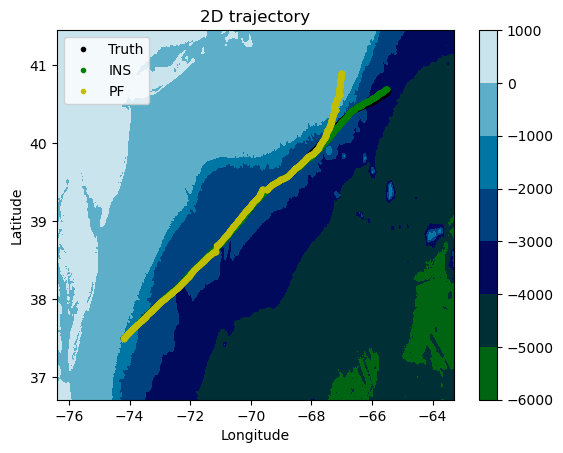

In [7]:
plt.contourf(bathy_map.map_data.lon, bathy_map.map_data.lat,
             bathy_map.map_data, cmap='ocean')
plt.plot(truth.lon, truth.lat, 'k.', label="Truth")
plt.plot(trajectory.lon, trajectory.lat, 'g.', label="INS")
plt.plot(result.lon, result.lat, 'y.', label="PF")
plt.colorbar()
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("2D trajectory")
#plt.xlim(min_lon, max_lon)
#plt.ylim(min_lat, max_lat)
plt.legend()
plt.show()

In [ ]:
hsv = hs.haversine_vector(truth[["lat", "lon"]].to_numpy(), result[["lat", "lon"]].to_numpy(), hs.Unit.METERS)
plt.plot(result.index, result['rms_error_2d'], 'b')
plt.plot(result.index, hsv, 'g')
plt.plot(result.index, result['estimate_error'], 'y')
plt.ylim(0, 3000)
plt.axhline(1852)
plt.axhline(452, color='r')
plt.show()

In [364]:
summary = pd.DataFrame()
error_summary = pd.Series(err, distance)
summary[f"{j}"] = error_summary

In [ ]:
plt.plot(distance, estimate[:, 3:6])

In [ ]:
# Plot the results as a function of distance traveled
plt.plot(
    distance / 1852,
    100 * np.sqrt(ins_errors.north**2 + ins_errors.east**2) / distance,
    'g-',
    label="INS error",
)
plt.plot(
    distance / 1852,
    100 * np.sqrt(integrator_error.north**2 + integrator_error.east**2) / distance,
    'r.',
    label="integrator error",
)
plt.xlabel("Distance traveled (nmi)")
plt.ylabel("Position error (% of distance traveled)")
plt.title("Radial position error vs. distance traveled")
plt.legend()
plt.ylim(0, 100)
plt.show()

# Data Post Processing

Use this section to load and post process the results data set

In [91]:
import os
import numpy as np
import pandas as pd
import haversine as hs
from matplotlib import pyplot as plt
from glob import glob
import h5py
from src.geophysical import gmt_toolbox as gmt

def load_simulation_results(filename:str) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    # Open the HDF5 file
    with h5py.File(filename, 'r') as f:
        # Load the result dataframe
        result_data = {column: f['result'][column][:] for column in f['result']}
        result = pd.DataFrame(result_data)
        
        # Load the feedback.trajectory dataframe
        trajectory_data = {column: f['trajectory'][column][:] for column in f['trajectory']}
        trajectory = pd.DataFrame(trajectory_data)
        
        # Load the feedback.trajectory_sd dataframe
        trajectory_sd_data = {column: f['trajectory_sd'][column][:] for column in f['trajectory_sd']}
        trajectory_sd = pd.DataFrame(trajectory_sd_data)

    distance = hs.haversine_vector(
    trajectory[["lat", "lon"]].to_numpy(), 
    trajectory[["lat", "lon"]].shift(1).to_numpy(), hs.Unit.METERS)
    distance = np.cumsum(np.nan_to_num(distance, nan=0))

    time = trajectory.index.to_numpy() 

    result["distance"] = distance
    trajectory["distance"] = distance
    #trajectory_sd["distance"] = distance

    return result, trajectory, trajectory_sd

In [92]:
result_files = glob(os.path.join("scripts", "bathy_pf_results", "*.h5"))

In [93]:
result, trajectory, trajectory_std = load_simulation_results(result_files[10])

In [67]:
result.head()

,alt,alt_var,estimate_error,lat,lat_var,lon,lon_var,rms_error_2d,rms_error_3d,vd,vd_var,ve,ve_var,vn,vn_var
0,-0.002221,1.007271,51.698248,44.828789,0.010017,-54.886554,0.010002,43.135079,43.135080,0.016140,0.099635,-0.087794,0.100173,-7.545106,0.099474
1,-1.474768,99.869934,9637.980062,44.741949,0.002499,-54.921607,0.004703,39.125082,39.125095,0.016020,0.019813,-0.069699,3.529414,-7.551944,3.499712
2,-4.019621,147.347940,10552.809291,44.730710,0.002109,-54.924847,0.004384,40.589662,40.589682,0.061712,0.021133,0.242859,3.491174,-4.645135,3.517749
3,-8.171548,202.770630,10603.935439,44.726934,0.001984,-54.926672,0.004420,40.561369,40.561402,0.075231,0.022052,-0.865730,3.493975,-6.748177,3.515603
4,-10.871194,274.429914,10423.002881,44.724276,0.001897,-54.929535,0.004553,40.058463,40.058512,0.018002,0.023050,-2.074768,3.499111,-7.830546,3.518014


In [112]:
estimate_error_summary = pd.DataFrame()
rms_2d_summary = pd.DataFrame()
rms_3d_summary = pd.DataFrame()
distances = pd.DataFrame()

for root, dirs, files in os.walk("scripts/bathy_pf_results"):
    for file in files:
        if file.endswith(".h5"):
            filename = os.path.join(root, file)
            result, trajectory, trajectory_std = load_simulation_results(filename)
            estimate_error = result["estimate_error"].rename(file)
            estimate_error.index = result["distance"]
            estimate_error_summary = pd.merge(estimate_error_summary, estimate_error, left_index=True, right_index=True, how='outer')
    #rms_2d_summary = pd.concat([rms_2d_summary, result["rms_error_2d"]], axis=1)
    #rms_3d_summary = pd.concat([rms_3d_summary, result["rms_error_3d"]], axis=1)
    #distances = pd.concat([distances, result["distance"]], axis=1)
    

In [113]:
estimate_error_summary.head()

,wi933014_37.h5,index17_106.h5,wi933014_14.h5,index17_85.h5,wi933014_24.h5,wi933014_29.h5,wi933014_63.h5,index17_84.h5,wi933014_13.h5,wi933014_25.h5,...,wi933014_70.h5,wi933014_54.h5,wi933014_66.h5,wi933014_10.h5,wi933014_53.h5,wi933014_80.h5,wi933014_6.h5,wi933014_27.h5,wi933014_57.h5,wi933014_62.h5
distance,,,,,,,,,,,,,,,,,,,,,
0.000000,7.664071,66.343673,70.360219,46.351337,12.538943,52.08432,54.008636,48.39773,57.314059,43.765245,...,55.791566,26.212644,28.891702,18.062173,100.0825,20.084424,38.720216,26.879722,28.595834,20.305071
1.552875,NaN,4066.479741,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4.633196,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4.980939,NaN,NaN,NaN,110.832868,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5.015546,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<Axes: xlabel='distance'>

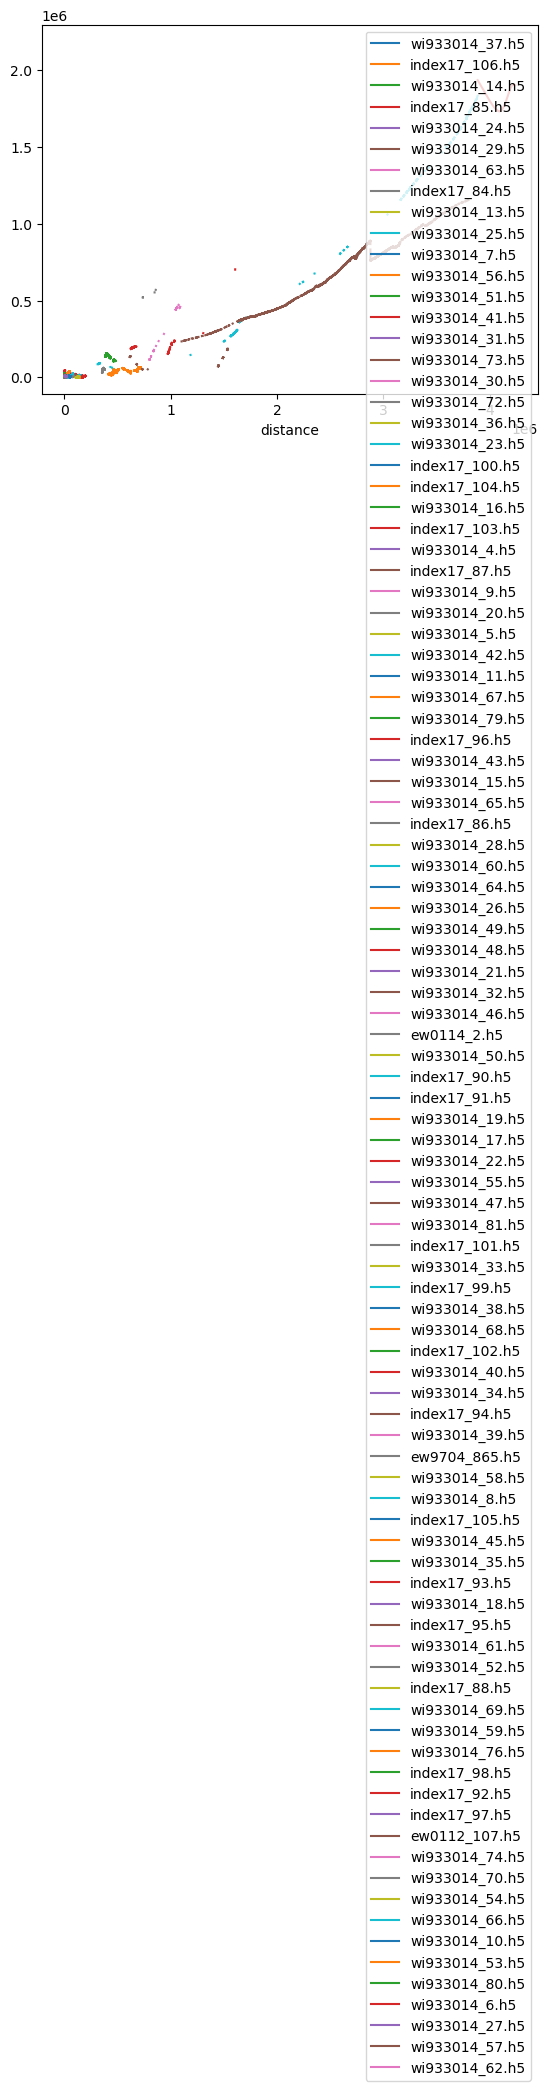

In [137]:
estimate_error_summary.rolling(window=1, min_periods=1, step=1).mean().plot()

In [122]:
mean_error = estimate_error_summary.mean(axis=1, skipna=True)
mean_error

distance
0.000000e+00    3.797447e+01
1.552875e+00    4.066480e+03
4.633196e+00    3.170220e+03
4.980939e+00    1.108329e+02
5.015546e+00    9.840968e+02
                    ...     
4.222552e+06    1.905538e+06
4.226833e+06    1.905757e+06
4.231323e+06    1.905222e+06
4.236049e+06    1.904123e+06
4.240413e+06    1.902137e+06
Length: 94623, dtype: float64

<Axes: xlabel='distance'>

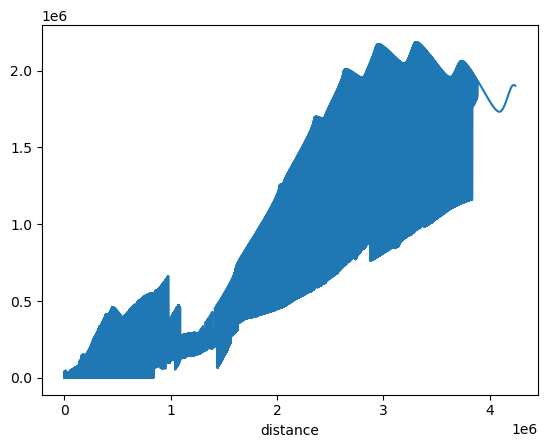

In [123]:
mean_error.plot()

In [135]:
means = mean_error.rolling(window=1, min_periods=1, step=1).mean()

In [136]:
len(means)

94623

<Axes: xlabel='distance'>

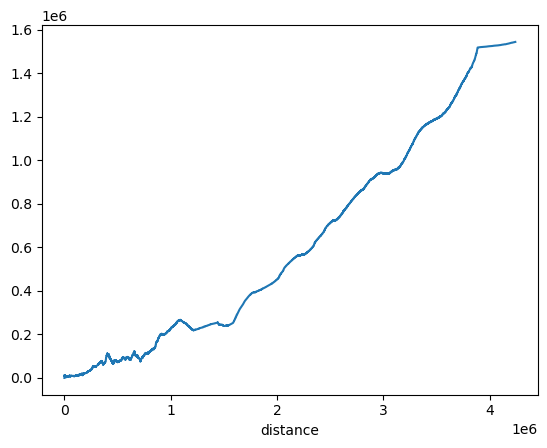

In [140]:
mean_error.rolling(1000, min_periods=1, step=1).mean().plot()

<Axes: xlabel='distance'>

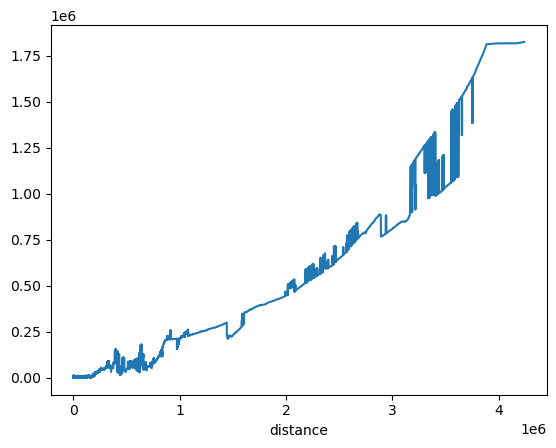

In [134]:
mean_error.rolling(100, min_periods=1).median().plot()

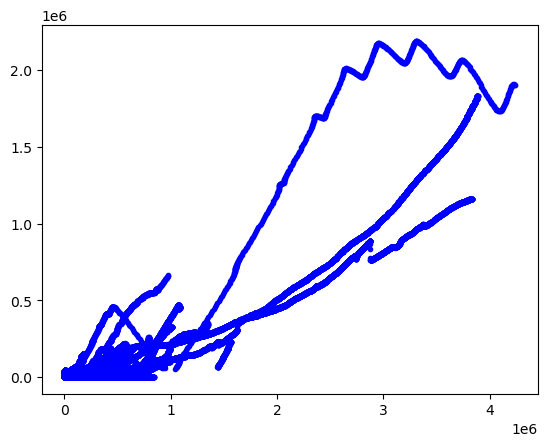

In [ ]:
plt.plot(estimate_error_summary.index, estimate_error_summary["mean"], '.b')

In [86]:
estimate_error_summary = pd.concat([estimate_error_summary, resultb["estimate_error"]], axis=1) 

In [87]:
estimate_error_summary.mean(axis=1)

0        57.314059
1      2164.276837
2      3657.214484
3      2875.133984
4      2645.568439
          ...     
338    1089.952798
339    1195.299798
340    1196.434041
341    1363.818901
342    1429.557269
Length: 343, dtype: float64

In [68]:
trajectory.head()

,VD,VE,VN,alt,dt,heading,lat,lon,pitch,roll
0,0.016286,-0.084776,-7.546957,0.654847,0.0,158.281407,44.828308,-54.886705,0.000000,0.000000
1,0.058389,0.258240,-4.634509,-3.126756,60.0,165.559538,44.825046,-54.886649,0.109036,-0.009542
2,0.072892,-0.855856,-6.733354,-7.867767,60.0,171.999214,44.821676,-54.886747,-0.109285,-0.027764
3,0.016303,-2.068205,-7.854582,-2.589343,60.0,175.331662,44.818256,-54.888376,-0.004509,0.031818
4,0.005037,0.328274,-9.051805,-1.062468,60.0,176.721975,44.813348,-54.888519,-0.050860,-0.001428


The goal of this experiment is to test the particle filter's ability to estimate the true state, either by maintaining an originally accurate estimate, or by recovering from a de-localized state. We are simulating a marine-grade INS with a drift rate of 1 nm per 24 hours, but comparing and propagting this sytem to a true INS value with GPS measurements.

Error metrics we are interested in:

1. Raw particle filter estimate error in meters plus the standard deviation of the particle filter estimate (a measure of overall accuracy and confidence)
2. Particle filter error normalized by the distance traveled by the platform (a measure of the relative error)
3. Particle filter error normalized by drift rate (indicates how much of the error is due to the drift rate, and how much is due to the particle filter) which should demonstrate it's suitability as a long-term navigation aide for position feedback.
4. Particle filter error (possibly normalized as above) as a percentage of map pixel resolution (15 arcseconds, ~452 meters).

Key finding that we want to prove is that the particle filter can estimate the true state to within the resolution of a given map pixel. This is a key finding as it demonstrates the particle filter's ability to provide a position fix in the absence of GPS that is better than the resolution of the map. Alternatively, if we had an arbitrary map where each pixel had a completely unique signature, the measurement model would only be able to report the particle filter's estimate to within the resolution of the map. Subsequent movements and measurments could then be used to refine the estimate. Because geophysical maps and measurements are not unique, the ability of the particle filter to estimate the true state to within the resolution of the map is a key finding that indicates a performance level that approaches a theoretical limit.

### General idea

Consider a grid based map $m$ with entirely unique signatures $m = \left[m_0 \dots m_n\right]$ where $m_i \neq m_j$ for all $i \neq j$. We have a means to measure that signature with perfect accuracy maing the measurement model $p(z | m) = 1$ for $z = m_i$, and zero elsewhere. $\text{bel}(x_t) = \text{bel}(x_{t-1}) * p(z | m)$. To derive a navigation fix we would then take the maximum value of $\text{bel}(x_t)$ and use that as the navigation fix. However, without knowledge of motion, the state space is similarly limited to the grid cell size. With knowledge of motion, this measurement function becomes a lower limit to the amount of error the position estimate can be resolved to.

In [69]:
distance = hs.haversine_vector(
    trajectory[["lat", "lon"]].to_numpy(), 
    trajectory[["lat", "lon"]].shift(1).to_numpy(), hs.Unit.METERS)
distance = np.cumsum(np.nan_to_num(distance, nan=0))
trajectory["distance"] = distance

time_index = trajectory.index.to_numpy() * 60

duration = time_index[-1] / (24*3600)
drift = duration * 1852
drift_rate = np.arange(0, drift, drift / len(result))

In [70]:
two_d = trajectory_std[["north", "east"]]
ins_certainty = np.sqrt(hs.haversine_vector(two_d.to_numpy(), np.zeros(two_d.shape), hs.Unit.METERS)**2 + trajectory_std["down"]**2)

### General Estimate accuracy

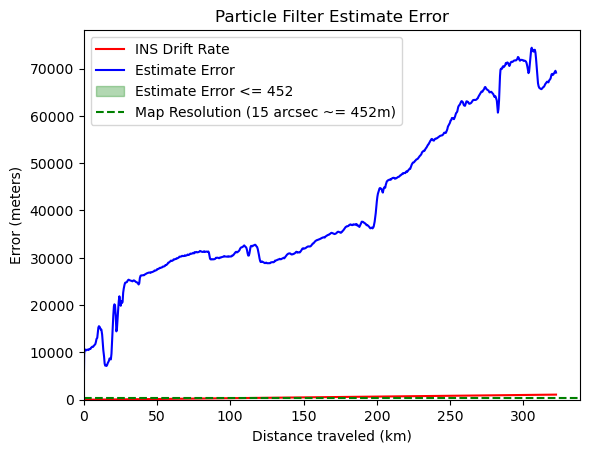

In [71]:
plt.plot(trajectory["distance"] / 1000, drift_rate, 'r', label="INS Drift Rate")
plt.plot(trajectory["distance"] / 1000, result["estimate_error"].to_numpy(), 'b', label="Estimate Error")
plt.fill_between(trajectory["distance"] / 1000, 
                 result["estimate_error"],
                 452,
                 where=result["estimate_error"] <= 452, color='green', alpha=0.3, label='Estimate Error <= 452')
plt.axhline(452, color='g', linestyle='--', label='Map Resolution (15 arcsec ~= 452m)')
plt.xlabel("Distance traveled (km)")
plt.ylabel("Error (meters)")
plt.xlim(left=0)
plt.ylim(bottom=0)
plt.legend()
plt.title("Particle Filter Estimate Error")
plt.show()

### Estimate accuracy w.r.t. distance traveled

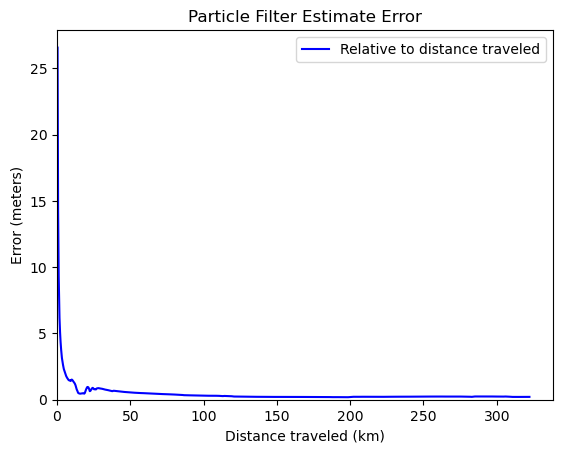

In [72]:
plt.plot(trajectory["distance"] / 1000, result["estimate_error"].to_numpy() / trajectory["distance"], 'b', label="Relative to distance traveled")
#plt.plot(trajectory["distance"] / 1000, result["estimate_error"].to_numpy() / drift_rate, 'r', label="Relative to INS drift rate")
# plt.fill_between(trajectory["distance"] / 1000, 
#                  result["estimate_error"] / trajectory["distance"],
#                  452 / trajectory["distance"],
#                  where=result["estimate_error"] <= 452, color='green', alpha=0.3, label='Estimate Error <= 452')
#plt.axhline(452, color='g', linestyle='--', label='Map Resolution (15 arcsec ~= 452m)')
plt.xlabel("Distance traveled (km)")
plt.ylabel("Error (meters)")
plt.xlim(left=0)
plt.ylim(bottom=0)
plt.legend()
plt.title("Particle Filter Estimate Error")
plt.show()

In [ ]:
# check to see if all the tables in results_tables are present in summary["name"] and if not capture the missing tables
missing = []
for table in results_tables:
    if table not in summary["name"].values:
        missing.append(table)

total = len(results_tables)
num_recoveries = total - len(missing)
print(
    f"There are {total} total trajectories. We were able to recover at least one position fix below drift error in {num_recoveries} ({num_recoveries / total :0.4f}) trajectories."
)

In [ ]:
pixel = summary.loc[summary["min error"] <= 452]

# check to see if the tables in pixel are present in summary["name"] and if not capture the missing tables
missing = []
for table in results_tables:
    if table not in pixel["name"].values:
        missing.append(table)
below_pixel_fixes = total - len(missing)

print(
    f"There are {len(pixel)} total below pixel resolution fixes. We were able to achieve at least one position estimate below drift error in {below_pixel_fixes} ({below_pixel_fixes/total :0.4f}) trajectories."
)
print(f"mean duration: {pixel['duration'].mean()} and median duration: {pixel['duration'].median()}")
print(f"mean error: {pixel['min error'].mean()} and median error: {pixel['min error'].median()}")
print(f"minium duration: {pixel['duration'].min()} and maximum duration: {pixel['duration'].max()}")
print(f"minimum error: {pixel['min error'].min()} and maximum error: {pixel['min error'].max()}")
print(f"mean start: {pixel['start'].mean()} and median start: {pixel['start'].median()}")

In [ ]:
summary.sort_values(by="min error").head(3)

In [ ]:
summary.sort_values(by="start").head(3)

In [ ]:
summary.sort_values(by="duration").tail(3)

In [ ]:
summary.sort_values(by="average_error").head(3)

In [ ]:
# Find the line in summary that has the closest to the mean duration
summary.loc[abs(summary["duration"] - summary["duration"].median()) <= timedelta(minutes=1)]

In [ ]:
summary["duration"].median()

In [ ]:
print(
    f"On average we were able to recover a position fix with an mean duration of {summary['duration'].mean()}, median duration of {summary['duration'].median()} and a mean error of {summary['average_error'].mean()} and median error {summary['average_error'].median()}."
)

print(f"Minimum duration {summary['duration'].min()} and maximum duration {summary['duration'].max()}.")
print(f"Minimum error {summary['average_error'].min()} and maximum error {summary['average_error'].max()}.")

In [ ]:
first = summary.loc[summary["num"] == 0]
# first.head()

print(
    f"The first position recover occurs with a mean of {first['start'].mean()} and median {first['start'].median()} after the start of the trajectory."
)
print(
    f"with an mean duration of {first['duration'].mean()}, median duration of {first['duration'].median()} and a mean error of {first['average_error'].mean()} and median error {first['average_error'].median()}."
)

print(f"Minimum duration {first['duration'].min()} and maximum duration {first['duration'].max()}.")
print(f"Minimum error {first['average_error'].min()} and maximum error {first['average_error'].max()}.")

# Gravity

Recreate the above simulation and measurment model development this time with gravity

In [ ]:
from src.gmt_tool import inflate_bounds, get_map_section, get_map_point
import src.process_dataset as pdset
import numpy as np
import json
from matplotlib import pyplot as plt
import os

config = json.load(open("config.json", "r"))
tables = pdset.get_tables(".db/parsed.db")
gravity_tables = [table for table in tables if "_G_" in table]

In [ ]:
d_gravity = np.array([])

for table in gravity_tables:
    data = pdset.table_to_df(".db/parsed.db", table)
    min_lon = data.LON.min()
    max_lon = data.LON.max()
    min_lat = data.LAT.min()
    max_lat = data.LAT.max()
    min_lon, min_lat, max_lon, max_lat = inflate_bounds(min_lon, min_lat, max_lon, max_lat, 0.25)
    gravity_map = get_map_section(min_lon, max_lon, min_lat, max_lat, "gravity", "01m", "temp")
    d_gravity = np.hstack([d_gravity, data["GRAV_ANOM"] - get_map_point(gravity_map, data.LON, data.LAT)])

config["gravity_mean_d"] = np.mean(d_gravity, where=~np.isnan(d_gravity))
config["gravity_std"] = np.std(d_gravity, where=~np.isnan(d_gravity))

if os.path.exists("config.json"):
    # delete the file
    os.remove("config.json")

with open("config.json", "w") as f:
    json.dump(config, f)

plt.hist(d_gravity, bins=100, density=True)
plt.xlim([-50, 75])
plt.xlabel("Gravity Difference (mGal)")
plt.ylabel("Frequency")
plt.title("Gravity Anomaly Difference")
plt.savefig(".db/plots/gravity_diff.png")
plt.show()

# Magnetics

Recreation with magnetics

In [ ]:
from src.gmt_tool import inflate_bounds, get_map_section, get_map_point
import numpy as np
import json

config = json.load(open("config.json", "r"))
tables = pdset.get_tables(".db/parsed.db")
mag_tables = [table for table in tables if "_M_" in table]

df = pdset.table_to_df(".db/parsed.db", mag_tables[0])
df.head()

In [ ]:
d_magnetics = np.array([])

for table in mag_tables:
    data = pdset.table_to_df(".db/parsed.db", table)
    min_lon = data.LON.min()
    max_lon = data.LON.max()
    min_lat = data.LAT.min()
    max_lat = data.LAT.max()
    min_lon, min_lat, max_lon, max_lat = inflate_bounds(min_lon, min_lat, max_lon, max_lat, 0.25)
    mag_map = get_map_section(min_lon, max_lon, min_lat, max_lat, "magnetic", "02m", "temp")
    d_magnetics = np.hstack([d_magnetics, data["MAG_RES"] - get_map_point(mag_map, data.LON, data.LAT)])

config["magnetic_mean_d"] = np.mean(d_magnetics, where=~np.isnan(d_magnetics))
config["magnetic_std"] = np.std(d_magnetics, where=~np.isnan(d_magnetics))

if os.path.exists("config.json"):
    # delete the file
    os.remove("config.json")

with open("config.json", "w") as f:
    json.dump(config, f)

In [ ]:
plt.hist(d_magnetics, bins=100, density=True)
plt.xlim([-500, 500])
plt.xlabel("Magnetic Difference (nT)")
plt.ylabel("Frequency")
plt.title("Magnetic Residual Difference")
plt.savefig(".db/plots/mag_diff.png")
plt.show()